In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


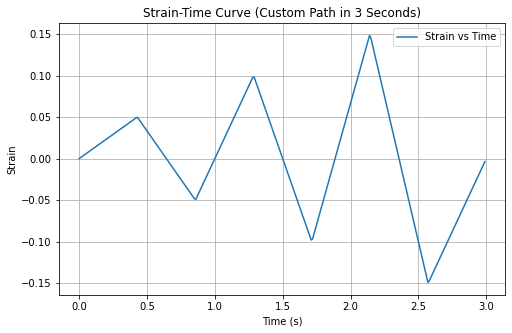

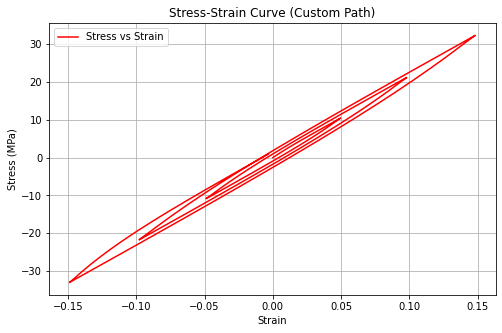

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the viscoelastic model
A = 200  # Elastic stiffness matrix (scalar for simplicity) in MPa
Q = 10   # Kernel decay rate
D = 50   # Damping coefficient (strain rate effect) in MPa·s
dt = 0.01  # Time step

# Define the time array (3 seconds total)
total_time = 3  # Total time for the custom strain path
time = np.arange(0, total_time, dt)  # Time array

# Define custom strain points and corresponding time points
custom_strain_points = [0, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0]  # Strain values
custom_time_points = np.linspace(0, total_time, len(custom_strain_points))  # Equally spaced time points

# Interpolate to create the strain path
strain_interpolator = np.interp(time, custom_time_points, custom_strain_points)
strain = strain_interpolator

# Strain rate (dE/dt)
strain_rate = np.gradient(strain, dt)

# Initialize stress array
stress = np.zeros_like(time)

# Compute stress using the convolution integral
for i in range(1, len(time)):
    elastic_stress = A * strain[i]  # Elastic component
    
    # Convolution integral for the viscoelastic component
    viscoelastic_stress = 0
    for j in range(i):
        kernel = np.exp(-Q * (time[i] - time[j]))
        viscoelastic_stress += kernel * D * strain_rate[j] * dt
    
    # Total stress is the sum of elastic and viscoelastic components
    stress[i] = elastic_stress + viscoelastic_stress

# Plot the strain-time curve
plt.figure(figsize=(8, 5))
plt.plot(time, strain, label="Strain vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain-Time Curve (Custom Path in 3 Seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Plot the stress-strain curve
plt.figure(figsize=(8, 5))
plt.plot(strain, stress, label="Stress vs Strain", color="r")
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve (Custom Path)")
plt.grid(True)
plt.legend()
plt.show()


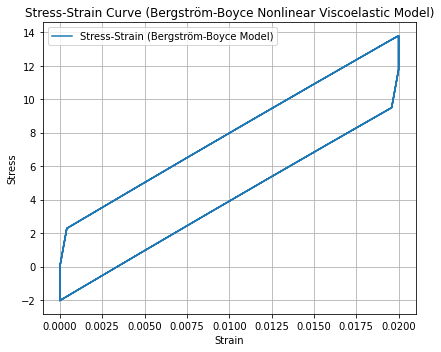

In [7]:
# Function to simulate stress using the Bergström-Boyce (BB) nonlinear viscoelastic model
def bergstrom_boyce_model(E0, eta, strain, dt):
    """
    Bergström-Boyce (BB) nonlinear viscoelastic model for generating stress based on strain and strain rate.
    
    Governing equation:
    σ(t) = σ_elastic(t) + σ_viscoelastic(t)
    where:
    σ_elastic(t) = E0 * (λ(t) - λ(t)^-2)
    σ_viscoelastic(t) = η * dε/dt
    
    :param E0: Elastic modulus
    :param eta: Viscosity term for strain rate
    :param strain: Array of applied strain over time
    :param dt: Time step for numerical integration
    :return: Stress corresponding to the applied strain
    """
    num_points = len(strain)
    stress = np.zeros(num_points)  # Initialize the stress array
    
    # Calculate stretch ratio λ(t) = 1 + ε(t)
    stretch = 1 + strain
    
    # Euler integration loop to calculate stress based on the BB model
    for i in range(1, num_points):
        # Strain rate (dε/dt)
        strain_rate = (strain[i] - strain[i - 1]) / dt
        
        # Elastic stress component
        stress_elastic = E0 * (stretch[i] - stretch[i]**-2)
        
        # Viscoelastic stress component (depends on strain rate)
        stress_viscoelastic = eta * strain_rate
        
        # Total stress is the sum of elastic and viscoelastic components
        stress[i] = stress_elastic + stress_viscoelastic
    
    return stress

# Parameters for the Bergström-Boyce model
E0 = 200.0  # Elastic modulus
eta = 50.0  # Viscosity term for strain rate

# Time and strain for multiple cycles of loading and unloading
num_cycles = 3  # Number of cycles of loading/unloading
num_points_per_cycle = 100
total_points = num_cycles * num_points_per_cycle
time = np.linspace(0, num_cycles, total_points)
dt = time[1] - time[0]  # Time step

# Apply multiple cycles of loading/unloading strain: linear ramp up/down
strain = np.zeros(total_points)
for cycle in range(num_cycles):
    start = cycle * num_points_per_cycle
    end = start + num_points_per_cycle
    half_cycle = num_points_per_cycle // 2
    strain[start:start + half_cycle] = np.linspace(0, 0.02, half_cycle)
    strain[start + half_cycle:end] = np.linspace(0.02, 0, half_cycle)

# Generate stress using the Bergström-Boyce (BB) model
stress = bergstrom_boyce_model(E0, eta, strain, dt)

# Plot the stress-strain curve
plt.figure(figsize=(6, 5))
plt.plot(strain, stress, label="Stress-Strain (Bergström-Boyce Model)")
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title("Stress-Strain Curve (Bergström-Boyce Nonlinear Viscoelastic Model)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


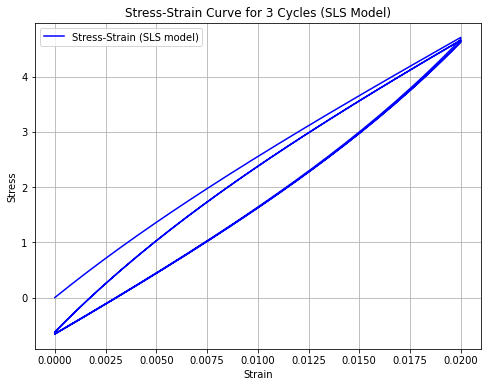

In [8]:
# Function to generate stress based on the SLS model
def sls_model(E1, E2, eta, strain, dt):
    """
    Standard Linear Solid (SLS) model.
    :param E1: Elastic modulus of the first spring (elastic part)
    :param E2: Elastic modulus of the second spring (viscoelastic part)
    :param eta: Viscosity of the dashpot
    :param strain: Applied strain over time
    :param dt: Time step
    :return: Stress corresponding to the applied strain
    """
    num_points = len(strain)
    stress = np.zeros(num_points)
    strain_dashpot = 0  # Initial condition: no strain in dashpot

    for i in range(1, num_points):
        # Incremental stress-strain relation in SLS model
        strain_rate = (strain[i] - strain[i - 1]) / dt
        strain_dashpot_rate = (E2 / eta) * (strain[i] - strain_dashpot)
        strain_dashpot += strain_dashpot_rate * dt
        stress[i] = E1 * strain[i] + E2 * (strain[i] - strain_dashpot)

    return stress

# Parameters for the SLS model
E1 = 200.0  # Elastic modulus of spring 1 (elastic part)
E2 = 100.0   # Elastic modulus of spring 2 (viscoelastic part)
eta = 20.0  # Viscosity of the dashpot

# Time and strain for 3 cycles of loading and unloading
num_cycles = 3
num_points_per_cycle = 100
total_points = num_cycles * num_points_per_cycle
time = np.linspace(0, num_cycles, total_points)
dt = time[1] - time[0]  # Time step

# Apply 3 cycles of loading/unloading strain: linear ramp up/down
strain = np.zeros(total_points)
for cycle in range(num_cycles):
    start = cycle * num_points_per_cycle
    end = start + num_points_per_cycle
    half_cycle = num_points_per_cycle // 2
    strain[start:start+half_cycle] = np.linspace(0, 0.02, half_cycle)
    strain[start+half_cycle:end] = np.linspace(0.02, 0, half_cycle)

# Generate stress using the SLS model
stress = sls_model(E1, E2, eta, strain, dt)

# Convert data to tensors for PyTorch
strain_tensor = torch.Tensor(strain).to(device)
stress_tensor = torch.Tensor(stress).to(device)

# Plot stress-strain curve for 3 cycles
plt.figure(figsize=(8, 6))
plt.plot(strain, stress, label="Stress-Strain (SLS model)", color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title("Stress-Strain Curve for 3 Cycles (SLS Model)")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Define the ANN model for elastic potential W
class ElasticPotential(nn.Module):
    def __init__(self, input_size=1, hidden_size=10):
        super(ElasticPotential, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.softplus_squared = nn.Softplus()

    def forward(self, x):
        x = self.softplus_squared(self.fc1(x))
        x = self.softplus_squared(self.fc2(x))
        return self.fc3(x)
    
# Define the ANN model for viscoelastic potential V
class ViscoelasticPotential(nn.Module):
    def __init__(self, input_size=2, hidden_size=10):
        super(ViscoelasticPotential, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.softplus_squared = nn.Softplus()

    def forward(self, x):
        x = self.softplus_squared(self.fc1(x))
        x = self.softplus_squared(self.fc2(x))
        return self.fc3(x)

# Define the dissipation potential G for internal variable evolution
class DissipationPotential(nn.Module):
    def __init__(self, input_size=2, hidden_size=10):
        super(DissipationPotential, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.softplus_squared = nn.Softplus()

    def forward(self, x):
        x = self.softplus_squared(self.fc1(x))
        x = self.softplus_squared(self.fc2(x))
        return self.fc3(x)


In [27]:
# Instantiate the models
W_model = ElasticPotential().to(device)
V_model = ViscoelasticPotential().to(device)
G_model = DissipationPotential().to(device)

In [1]:
# Define loss function (MSE Loss) and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(list(W_model.parameters()) + list(V_model.parameters()) + list(G_model.parameters()), lr=1e-3)

# Training loop
num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward pass for elastic potential W (using strain as input)
    W_output = W_model(strain.unsqueeze(1))
    
    # Forward pass for viscoelastic potential V (using strain and internal variable alpha as inputs)
    alpha = torch.zeros_like(strain).to(device)  # Simplified assumption: starting with zero internal variable
    V_input = torch.stack([strain, alpha], dim=1)
    V_output = V_model(V_input)
    
    # Total stress (W + V)
    predicted_stress = W_output + V_output
    
    # Compute loss
    loss = criterion(predicted_stress.squeeze(), stress)
    loss_history.append(loss.item())
    
    # Backpropagation and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Plot loss history
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.show()


NameError: name 'nn' is not defined

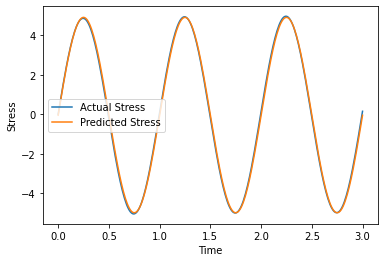

In [13]:
# Plot predicted stress vs actual stress
predicted_stress = W_model(strain.unsqueeze(1)) + V_model(torch.stack([strain, alpha], dim=1))
plt.plot(time.cpu().numpy(), stress.cpu().numpy(), label='Actual Stress')
plt.plot(time.cpu().numpy(), predicted_stress.squeeze().detach().cpu().numpy(), label='Predicted Stress')
plt.xlabel('Time')
plt.ylabel('Stress')
plt.legend()
plt.show()